<a href="https://colab.research.google.com/github/josejailson/CooperUnion/blob/main/cooperunion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução


Nesse projeto, iremos criar um modelo de regressão linear para predizer o preço de automóveis, a partir de características como marca, ano, quilometragem etc.

A princípio, o algoritmo será desenvolvido usando apenas o Numpy, mas em seguida exploraremos alguns métodos da biblioteca Scikit-Learn.

## Obtendo o conjunto de dados

In [ ]:
from google.colab import files

files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jailsonjunior314","key":"64dc0f2a81969ddfe33849b759eabf40"}'}

In [ ]:
!mkdir -p ~/.kaggle/

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download CooperUnion/cardataset

100% 103k/103k [00:00<00:00, 518kB/s]
100% 103k/103k [00:00<00:00, 517kB/s]


In [ ]:
!unzip \*.zip  && rm *.zip

Archive:  cardataset.zip
replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Análise exploratória dos dados

Nesse passo, quero saber quais variáveis nosso cojunto de dados possui, assim como a ditribuição dessas variáveis (inclusive a variável que queremos predizer). Também devemos examinar a qualidade dos dados e verificar se há dados faltando, entre outras coisas.

### Arrumando os dados

In [ ]:
import pandas as pd

df = pd.read_csv("data.csv")

In [ ]:
len(df)

11914

In [ ]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


In [ ]:
df.shape

(11914, 16)

In [ ]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [ ]:
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
  df[col] = df[col].str.lower().str.replace(' ', '_')

### Analisando a variável target

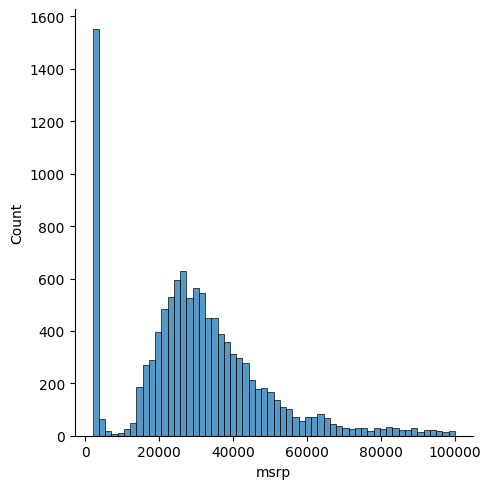

In [ ]:
import seaborn as sns

sns.displot(df.msrp[df.msrp < 100000], kde=False)

Note que há uma cauda longa (long tail) para valores acima de 60000. A maioria dos modelos de Machine Learning, inclusive a regressão linear, não lida muito bem com esse tipo de distribuição. Idealmente, queremo algo próximo de uma distribuição gaussiana (ou normal).
Assim, tomemos o logaritmo dessa variável.

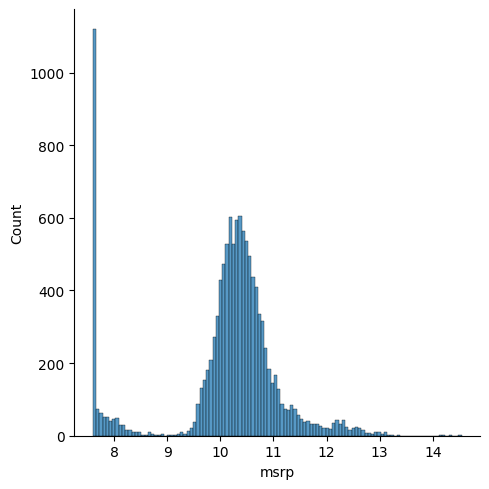

In [ ]:
import numpy as np

log_price = np.log1p(df.msrp)
sns.displot(log_price, kde=False)

### Verificando se há dados faltando

In [ ]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

### Obtendo os conjuntos de treinamento, validação e teste

In [ ]:
n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [ ]:
np.random.seed(2)
idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [ ]:
y_train = np.log1p(df_train.msrp.values)
y_test = np.log1p(df_test.msrp.values)
y_val  = np.log1p(df_val.msrp.values)

In [ ]:
for set_ in (df_train, df_test, df_val):
  set_ = set_.drop("msrp", axis=1)

## Implementando o modelo de regressão linear

In [ ]:
def linear_regression(X, y):
  ones = np.ones(X.shape[0])
  X = np.column_stack([ones, X])

  XTX = X.T.dot(X)
  XTX_inv = np.linalg.inv(XTX)
  w = XTX_inv.dot(X.T).dot(y)

  return w[0], w[1:]

In [ ]:
base = ["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg", "popularity"]
df_num = df_train[base]

In [ ]:
df_num = df_num.fillna(0)

In [ ]:
X_train = df_num.values

In [ ]:
w_0, w = linear_regression(X_train, y_train)

In [ ]:
y_pred = w_0 + X_train.dot(w)

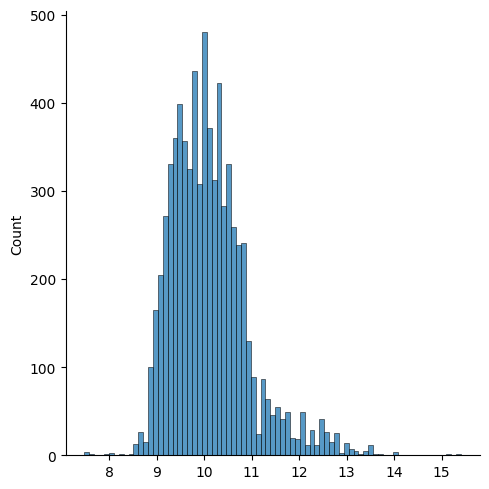

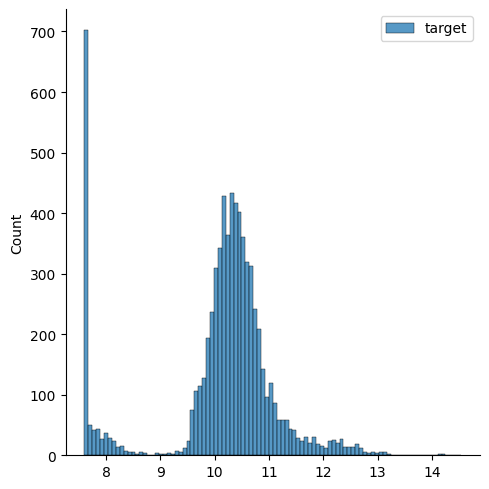

In [ ]:
import matplotlib.pyplot as plt


sns.displot(y_pred, label='prediction')
sns.displot(y_train, label='target')
plt.legend()

In [ ]:
def rmse(y, y_pred):
  error = y_pred - y
  mse = (error ** 2).mean()
  return np.sqrt(mse)

### Validando o modelo

In [ ]:
df_num = df_val[base]
df_num = df_num.fillna(0)
X_val = df_num.values

In [ ]:
y_pred = w_0 + X_val.dot(w)

In [ ]:
rmse(y_val, y_pred)

0.761653099130156

In [ ]:
def prepare_X(df):
  df = df.copy()
  features = base.copy()

  df['age'] = 2017 - df.year
  features.append('age')

  df_num = df[features]
  df_num = df_num.fillna(0)
  X = df_num.values
  return X

In [ ]:
X_train = prepare_X(df_train)
w_0, w = linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

validation: 0.5172055461058299


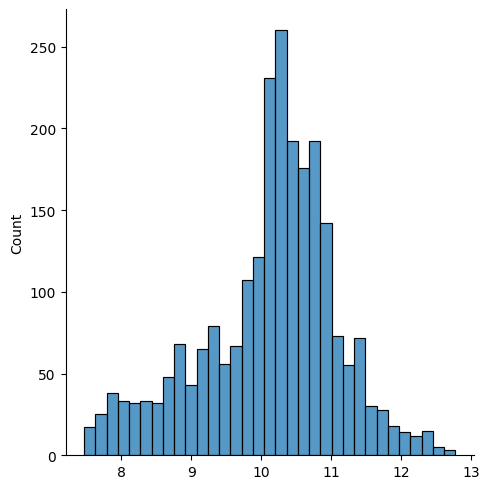

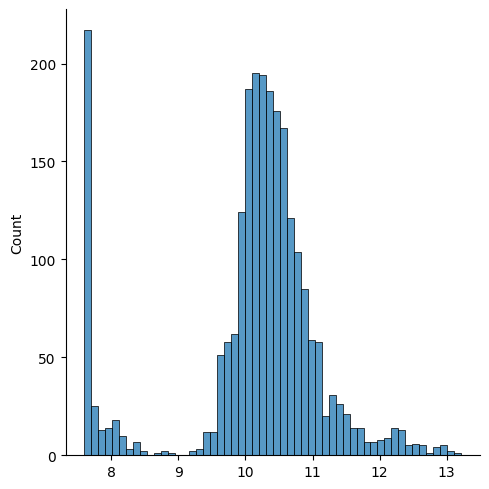

In [ ]:
sns.displot(y_pred, label="prediction")
sns.displot(y_val, label="target")

### Lidando com variáveis categóricas

In [ ]:
def prepare_X(df):
  df = df.copy()
  features = base.copy()

  df['age'] = 2017 - df.year
  features.append('age')

  for v in [2, 3, 4]:
    feature = 'num_doors_%s' % v
    df[feature] = (df['number_of_doors'] == v).astype(int)
    features.append(feature)

  for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
    feature = "is_make_%s" % v
    df[feature] = (df['make'] == v).astype(int)
    features.append(feature)

  df_num = df[features]
  df_num = df_num.fillna(0)
  X = df_num.values
  return X


In [ ]:
X_train = prepare_X(df_train)
w_0, w = linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

validation: 0.5076038849556795


### Regularização

In [ ]:
def linear_regression_reg(X, y, r=0.0):
  ones = np.ones(X.shape[0])
  X = np.column_stack([ones, X])

  XTX = X.T.dot(X)
  reg = r * np.eye(XTX.shape[0])
  XTX = XTX + reg

  XTX_inv = np.linalg.inv(XTX)
  w = XTX_inv.dot(X.T).dot(y)

  return w[0], w[1:]

In [ ]:
def prepare_X(df):
  df = df.copy()
  features = base.copy()

  df['age'] = 2017 - df.year
  features.append('age')

  for v in [2, 3, 4]:
    feature = 'num_doors_%s' % v
    df[feature] = (df['number_of_doors'] == v).astype(int)
    features.append(feature)

  for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
    feature = "is_make_%s" % v
    df[feature] = (df['make'] == v).astype(int)
    features.append(feature)

  df_num = df[features]
  df_num = df_num.fillna(0)
  X = df_num.values
  return X


In [ ]:
X_train = prepare_X(df_train)
w_0, w = linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

## Ajustando o modelo

# Conclusão

In [ ]:
import pandas

dgf = pd.read_csv("t.csv", delimiter=",")

In [ ]:
df.describe()

# Um passeio pelo Scikit-Learn

In [ ]:
import pandas as pd

data = pd.read_csv("data.csv")

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

array([[<Axes: title={'center': 'Year'}>,
        <Axes: title={'center': 'Engine HP'}>,
        <Axes: title={'center': 'Engine Cylinders'}>],
       [<Axes: title={'center': 'Number of Doors'}>,
        <Axes: title={'center': 'highway MPG'}>,
        <Axes: title={'center': 'city mpg'}>],
       [<Axes: title={'center': 'Popularity'}>,
        <Axes: title={'center': 'MSRP'}>, <Axes: >]], dtype=object)

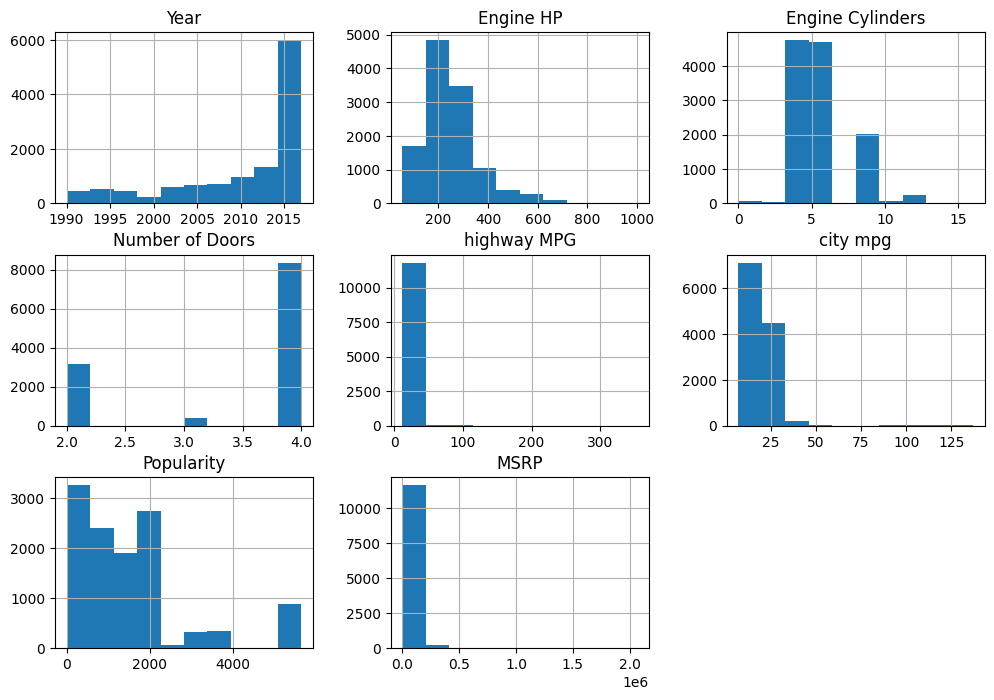

In [94]:
data.hist(figsize=(12, 8))

In [88]:
matrix_corr = data.corr()
matrix_corr["MSRP"].sort_values(ascending=False)

<ipython-input-88-34e20a5d4ccb>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix_corr = data.corr()


MSRP                1.000000
Engine HP           0.662008
Engine Cylinders    0.531312
Year                0.227590
Popularity         -0.048476
Number of Doors    -0.126635
city mpg           -0.157676
highway MPG        -0.160043
Name: MSRP, dtype: float64

array([[<Axes: xlabel='MSRP', ylabel='MSRP'>,
        <Axes: xlabel='Engine HP', ylabel='MSRP'>,
        <Axes: xlabel='Engine Cylinders', ylabel='MSRP'>,
        <Axes: xlabel='Year', ylabel='MSRP'>],
       [<Axes: xlabel='MSRP', ylabel='Engine HP'>,
        <Axes: xlabel='Engine HP', ylabel='Engine HP'>,
        <Axes: xlabel='Engine Cylinders', ylabel='Engine HP'>,
        <Axes: xlabel='Year', ylabel='Engine HP'>],
       [<Axes: xlabel='MSRP', ylabel='Engine Cylinders'>,
        <Axes: xlabel='Engine HP', ylabel='Engine Cylinders'>,
        <Axes: xlabel='Engine Cylinders', ylabel='Engine Cylinders'>,
        <Axes: xlabel='Year', ylabel='Engine Cylinders'>],
       [<Axes: xlabel='MSRP', ylabel='Year'>,
        <Axes: xlabel='Engine HP', ylabel='Year'>,
        <Axes: xlabel='Engine Cylinders', ylabel='Year'>,
        <Axes: xlabel='Year', ylabel='Year'>]], dtype=object)

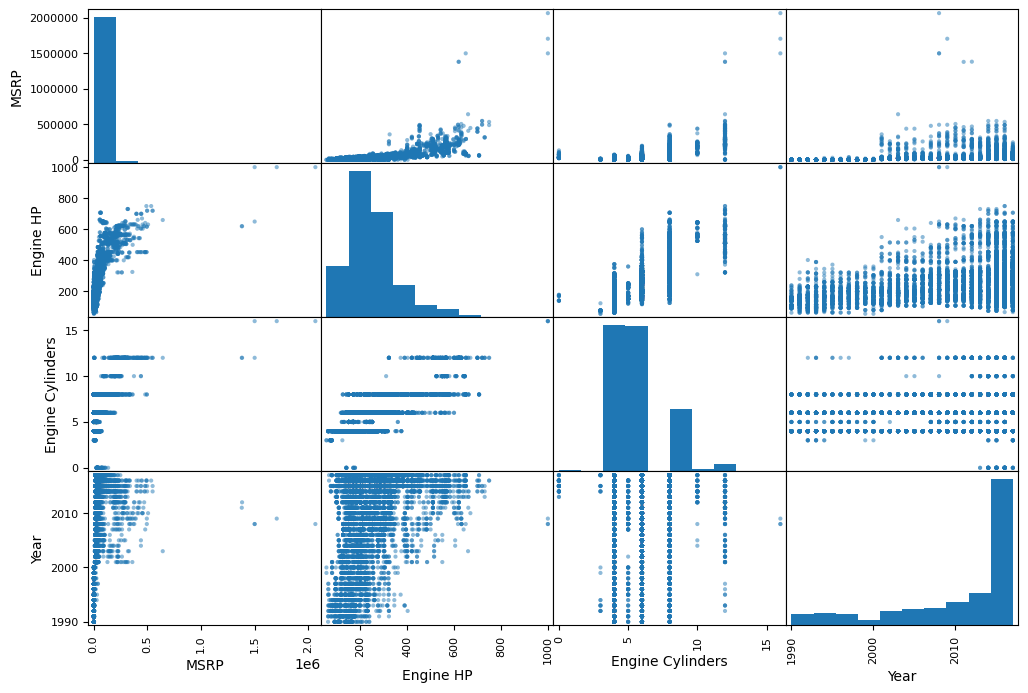

In [92]:
from pandas.plotting import scatter_matrix

attributes = ["MSRP", "Engine HP", "Engine Cylinders", "Year"]
scatter_matrix(data[attributes], figsize=(12,8))

In [77]:
X = data.drop("MSRP", axis=1)
y = data["MSRP"].copy()

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [79]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline


cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),
                             OneHotEncoder(handle_unknown="ignore",
                             sparse_output=False))
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [80]:
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

preprocessing = make_column_transformer(
    (cat_pipeline, make_column_selector(dtype_include=object)),
    (num_pipeline, make_column_selector(dtype_include=np.number))
)

In [81]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)
pipeline = make_pipeline(preprocessing, model)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f2d123980a0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f2d12398a90>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [82]:
from sklearn.model_selection import cross_val_score

score = cross_val_score(pipeline, X_train, y_train, cv=5)

In [85]:
score

array([0.97221095, 0.90876932, 0.97412627, 0.97368208, 0.94922137])

In [84]:
pd.Series(score).describe()

count    5.000000
mean     0.955602
std      0.028195
min      0.908769
25%      0.949221
50%      0.972211
75%      0.973682
max      0.974126
dtype: float64

In [86]:
import joblib

joblib.dump(pipeline, "baseline_random_forest.pkl")

['baseline_random_forest.pkl']

In [95]:
cross_val_score(pipeline, X_test, y_test, cv=5)

array([0.92583297, 0.92387464, 0.95514882, 0.64923932, 0.60542019])